# Timeseries_02-PlayWithModels

This is intended to load data prepared with the script `Timeseries_01-CompileInputData.R` and create a time series model predicting groundwater levels using the [`pastas`](https://pastas.readthedocs.io/en/latest/index.html) package.

It closely follows the [example on the `pastas` website](https://pastas.readthedocs.io/en/latest/examples/001_basic_model.ipynb.html).

## Set up workspace

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pastas as ps

## Load and check input data
We have data from three nested wells:
 - `LWPH4a` = shallow alluvial aquifer
 - `LWPH4b` = deep alluvial aquifer
 - `LWPH4c` = High Plains aquifer, separated from the alluvial aquifer by a (leaky?) confining layer.

We also have data about the river stage (`stage_masl`). This is `NaN` whenever flow in the river ceases.

The data type of the series is: <class 'pandas.core.frame.DataFrame'>
Variables are:  ['prcp_mm', 'tmax_c', 'tmin_c', 'ETo_mm', 'discharge_cms', 'stage_masl', 'WaterUse_m3d', 'LWPH4a', 'LWPH4a_source', 'LWPH4b', 'LWPH4b_source', 'LWPH4c', 'LWPH4c_source']


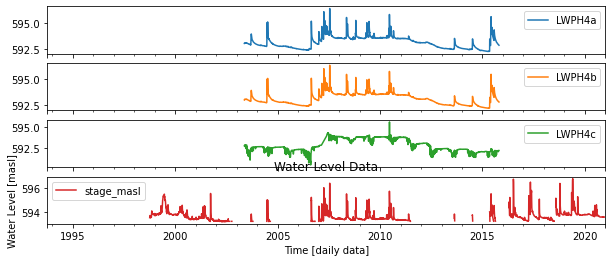

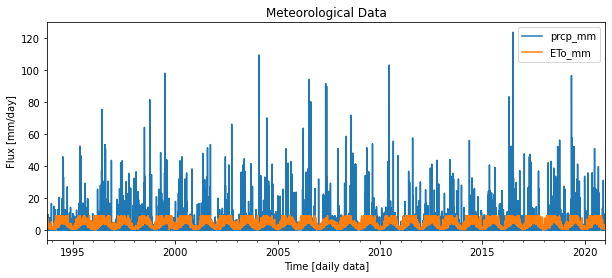

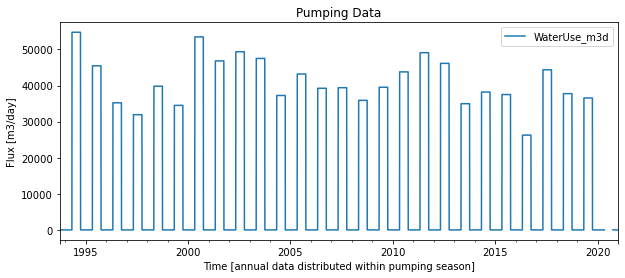

In [2]:
# Import input data time series and squeeze to Series object
inputdata = pd.read_csv('../data/Timeseries_InputData.csv', parse_dates=['date_ghcn'],
                        index_col='date_ghcn', squeeze=True)
print('The data type of the series is: %s' % type(inputdata))

# show names of columns
print('Variables are: ', list(inputdata))

# separate into water level data and meteorological data
hydrodata = inputdata[["LWPH4a", "LWPH4b", "LWPH4c", "stage_masl"]]
hydrodata.plot(figsize=(10, 4), subplots=True)
plt.title('Water Level Data');
plt.ylabel('Water Level [masl]');
plt.xlabel('Time [daily data]');

metdata = inputdata[["prcp_mm", "ETo_mm"]]
metdata.plot(figsize=(10, 4))
plt.title('Meteorological Data');
plt.ylabel('Flux [mm/day]');
plt.xlabel('Time [daily data]');

wusedata = inputdata[["WaterUse_m3d"]]
wusedata.plot(figsize=(10, 4))
plt.title('Pumping Data');
plt.ylabel('Flux [m3/day]');
plt.xlabel('Time [annual data distributed within pumping season]');

## Build simple model

INFO: Nan-values were removed at the start of the time series LWPH4a.
INFO: Nan-values were removed at the end of the time series LWPH4a.
INFO: Inferred frequency for time series LWPH4a: freq=D
INFO: Inferred frequency for time series prcp_mm: freq=D
INFO: Inferred frequency for time series ETo_mm: freq=D
INFO: Time Series prcp_mm was extended to 1993-05-18 00:00:00 with the mean value of the time series.
INFO: Time Series ETo_mm was extended to 1993-05-18 00:00:00 with the mean value of the time series.


Fit report LWPH4a                                    Fit Statistics
nfev    18                     EVP                   4.88
nobs    4543                   R2                   0.05
noise   1                      RMSE                   0.55
tmin    2003-05-16 00:00:00    AIC               16078.34
tmax    2015-10-22 00:00:00    BIC               16116.87
freq    D                      Obj                  17.18
warmup  3650 days 00:00:00     ___                       
solver  LeastSquares           Interp.                     No

Parameters (6 optimized)
                  optimal                   stderr    initial  vary
recharge_A   5.753237e-02                  ±10.64%   0.137042  True
recharge_n   2.631381e+00                   ±5.70%   1.000000  True
recharge_a   3.237085e+00                  ±10.69%  10.000000  True
recharge_f  -1.435224e-16  ±140856084929156096.00%  -1.000000  True
constant_d   7.796015e-01                  ±13.91%   0.888142  True
noise_alpha  7.662855e+01     

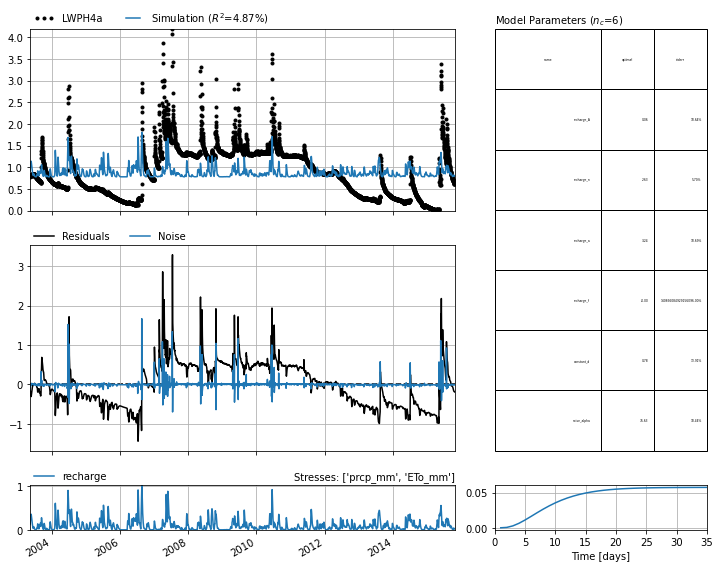

In [3]:
# normalize LWPH4a to min value
lwph4a = (hydrodata["LWPH4a"] - hydrodata["LWPH4a"].min()).asfreq("D")

# calculate daily precipitation surplus (P-ETo)
precSurplus_mm = metdata["prcp_mm"] - metdata["ETo_mm"]

# Create a model object by passing it the observed series
ml_lwph4a = ps.Model(lwph4a, name="LWPH4a")

# Add the recharge data as explanatory variable
#sm_precSurplus = ps.StressModel(precSurplus_mm, ps.Gamma, name='PrecSurplus', settings="evap")
#ml_lwph4a.add_stressmodel(sm_precSurplus)

# Add the recharge data as explanatory variable
sm_rech = ps.RechargeModel(metdata["prcp_mm"], metdata["ETo_mm"], rfunc=ps.Gamma, name="recharge")
ml_lwph4a.add_stressmodel(sm_rech)

# solve
ml_lwph4a.solve()

# plot
ml_lwph4a.plots.results(figsize=(10, 8))

# Let's store the simulated values to compare later
sim1 = ml_lwph4a.simulate()
res1 = ml_lwph4a.residuals()
n1 = ml_lwph4a.noise()

# Add pumping as stress component

Following example [here](https://pastas.readthedocs.io/en/latest/examples/005_adding_wells.ipynb.html).

INFO: Inferred frequency for time series WaterUse_m3d: freq=D
INFO: Time Series WaterUse_m3d: 153 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series WaterUse_m3d was extended to 1993-05-18 00:00:00 by adding 0.0 values.


Fit report LWPH4a                                        Fit Statistics
nfev    34                     EVP                      37.31
nobs    4543                   R2                       0.37
noise   1                      RMSE                       0.44
tmin    2003-05-16 00:00:00    AIC                   16089.68
tmax    2015-10-22 00:00:00    BIC                   16147.47
freq    D                      Obj                      17.13
warmup  3650 days 00:00:00     ___                           
solver  LeastSquares           Interp.                         No

Parameters (9 optimized)
                  optimal                                     stderr  \
recharge_A   6.014185e-02                                    ±10.55%   
recharge_n   2.589732e+00                                     ±5.59%   
recharge_a   3.375598e+00                                    ±10.61%   
recharge_f  -5.005303e-35  ±394294347440500078626998049763753984.00%   
well_A      -6.380269e+00                 

[<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:title={'right':"Stresses: ['prcp_mm', 'ETo_mm']"}>,
 <AxesSubplot:xlabel='Time [days]'>,
 <AxesSubplot:title={'right':"Stresses: ['WaterUse_m3d']"}>,
 <AxesSubplot:xlabel='Time [days]'>,
 <AxesSubplot:title={'left':'Model Parameters ($n_c$=9)'}>]

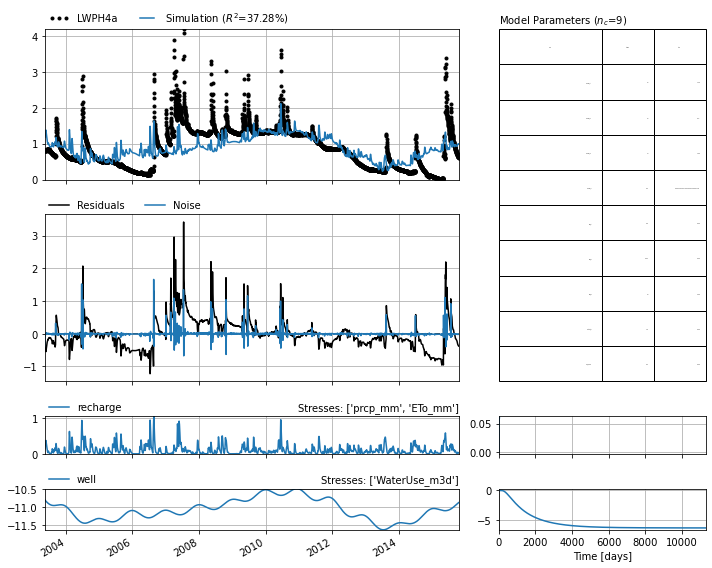

In [4]:
# create stress model
wuse = ps.StressModel(wusedata/1e4, rfunc=ps.Hantush, name="well", settings="well", up=False)

# add stress model
ml_lwph4a.add_stressmodel(wuse)

# Solve the model and make a plot
ml_lwph4a.solve()

# plot
ml_lwph4a.plots.results(figsize=(10, 8))

## Add river water levels as an additional stress component
Based on [this example](https://pastas.readthedocs.io/en/latest/examples/004_adding_rivers.ipynb.html).

INFO: Inferred frequency for time series stage_masl: freq=D
INFO: Time Series stage_masl was extended to 1993-05-18 00:00:00 with the mean value of the time series.


Fit report LWPH4a                    Fit Statistics
nfev    26                     EVP           56.83
nobs    4543                   R2             0.57
noise   1                      RMSE           0.37
tmin    2003-05-16 00:00:00    AIC         7574.25
tmax    2015-10-22 00:00:00    BIC         7638.46
freq    D                      Obj            2.63
warmup  3650 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (10 optimized)
                optimal    stderr     initial  vary
recharge_A     0.084453   ±26.57%    0.137042  True
recharge_n     1.787233    ±6.09%    1.000000  True
recharge_a    21.196669   ±22.02%   10.000000  True
recharge_f    -0.662596   ±57.45%   -1.000000  True
well_A        -0.450407  ±110.88%   -0.486449  True
well_a       341.909567  ±124.88%  100.000000  True
well_b         1.073230  ±137.64%    1.000000  True
river_d        0.895506    ±0.62%    0.388036  True
constant_d     1.601949   ±58.12%    0.888142

[<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:title={'right':"Stresses: ['prcp_mm', 'ETo_mm']"}>,
 <AxesSubplot:xlabel='Time [days]'>,
 <AxesSubplot:title={'right':"Stresses: ['WaterUse_m3d']"}>,
 <AxesSubplot:xlabel='Time [days]'>,
 <AxesSubplot:title={'right':"Stresses: ['stage_masl']"}>,
 <AxesSubplot:xlabel='Time [days]'>,
 <AxesSubplot:title={'left':'Model Parameters ($n_c$=10)'}>]

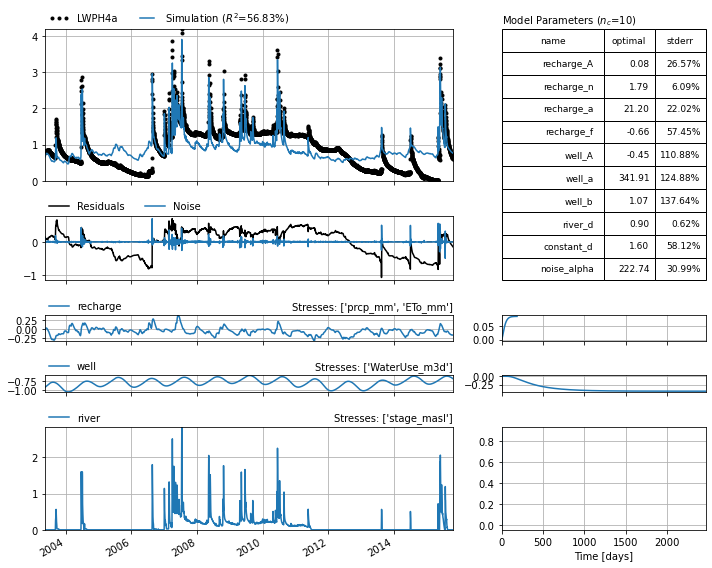

In [5]:
# add river water levels
river = (hydrodata["stage_masl"] - hydrodata["stage_masl"].min()).asfreq("D").fillna(0)

sm_river = ps.StressModel(river, rfunc=ps.One, name="river",
                           settings="waterlevel")
ml_lwph4a.add_stressmodel(sm_river)

# solve
ml_lwph4a.solve()

# plot
ml_lwph4a.plots.results(figsize=(10, 8))

## Remove pumping and instead use LWPH4c water levels

INFO: Nan-values were removed at the start of the time series LWPH4c.
INFO: Nan-values were removed at the end of the time series LWPH4c.
INFO: Inferred frequency for time series LWPH4c: freq=D
INFO: Time Series LWPH4c was extended to 1993-05-18 00:00:00 with the mean value of the time series.


Fit report LWPH4a                   Fit Statistics
nfev    26                     EVP           83.99
nobs    4543                   R2             0.84
noise   1                      RMSE           0.22
tmin    2003-05-16 00:00:00    AIC         7549.86
tmax    2015-10-22 00:00:00    BIC         7607.65
freq    D                      Obj            2.63
warmup  3650 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (9 optimized)
                optimal    stderr    initial  vary
recharge_A     0.108785   ±21.73%   0.137042  True
recharge_n     1.736393    ±5.67%   1.000000  True
recharge_a    25.965280   ±20.37%  10.000000  True
recharge_f    -0.116593  ±132.49%  -1.000000  True
river_d        0.895741    ±0.62%   0.388036  True
LWPH4c_A       0.439009   ±16.76%   1.351193  True
LWPH4c_a     154.779215   ±50.75%  10.000000  True
constant_d    -0.399946   ±46.26%   0.888142  True
noise_alpha   86.471059   ±21.12%   1.000000  True


[<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:title={'right':"Stresses: ['prcp_mm', 'ETo_mm']"}>,
 <AxesSubplot:xlabel='Time [days]'>,
 <AxesSubplot:title={'right':"Stresses: ['stage_masl']"}>,
 <AxesSubplot:xlabel='Time [days]'>,
 <AxesSubplot:title={'right':"Stresses: ['LWPH4c']"}>,
 <AxesSubplot:xlabel='Time [days]'>,
 <AxesSubplot:title={'left':'Model Parameters ($n_c$=9)'}>]

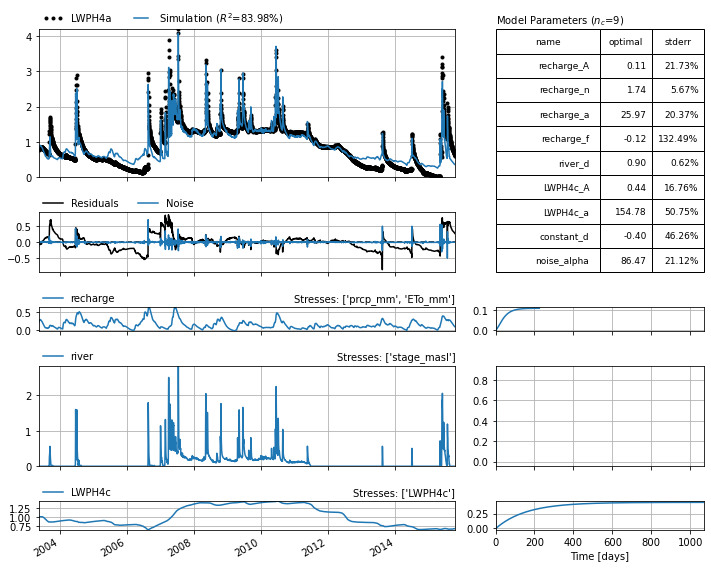

In [6]:
# add HPA water levels
lwph4c = (hydrodata["LWPH4c"] - hydrodata["LWPH4c"].min()).asfreq("D") # normalized to minimum observed value

sm_lwph4c = ps.StressModel(lwph4c, rfunc=ps.Exponential, name="LWPH4c",
                           settings="waterlevel")
ml_lwph4a.add_stressmodel(sm_lwph4c)
ml_lwph4a.del_stressmodel("well")

# solve
ml_lwph4a.solve()

# plot
ml_lwph4a.plots.results(figsize=(10, 8))

## try solving without noise model first, then add noise model

INFO: Time Series LWPH4c was extended to 1996-01-04 00:00:00 with the mean value of the time series.


Fit report LWPH4a                      Fit Statistics
nfev    29                     EVP           93.59
nobs    2923                   R2             0.94
noise   1                      RMSE           0.14
tmin    2006-01-01 00:00:00    AIC         3159.01
tmax    2014-01-01 00:00:00    BIC         3212.84
freq    D                      Obj            1.46
warmup  3650 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (9 optimized)
                 optimal    stderr      initial  vary
recharge_A      5.228569   ±15.22%     5.566809  True
recharge_n      1.214816    ±2.44%     1.180891  True
recharge_a   2295.275875   ±16.52%  2563.331855  True
recharge_f     -0.289589   ±27.47%    -0.310771  True
river_d         0.884684    ±0.54%     1.026003  True
LWPH4c_A        0.048566   ±81.76%     0.009741  True
LWPH4c_a        7.967642  ±103.05%     2.026437  True
constant_d     -2.944902   ±36.51%    -2.635585  True
noise_alpha    37.065552  

[<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:title={'right':"Stresses: ['prcp_mm', 'ETo_mm']"}>,
 <AxesSubplot:xlabel='Time [days]'>,
 <AxesSubplot:title={'right':"Stresses: ['stage_masl']"}>,
 <AxesSubplot:xlabel='Time [days]'>,
 <AxesSubplot:title={'right':"Stresses: ['LWPH4c']"}>,
 <AxesSubplot:xlabel='Time [days]'>,
 <AxesSubplot:title={'left':'Model Parameters ($n_c$=9)'}>]

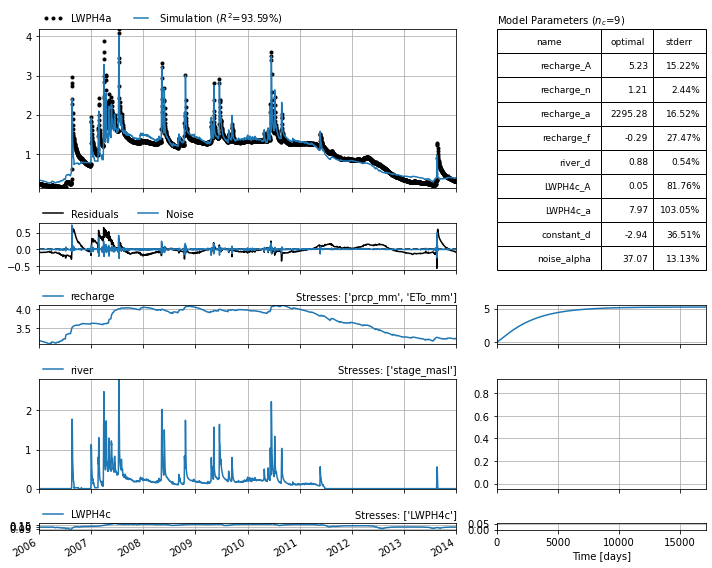

In [7]:
# solve
ml_lwph4a.solve(noise=False, report=False, tmin="2006", tmax="2014") # Solve first without noise model to improve initial parameters
ml_lwph4a.solve(noise=True, initial=False, tmin="2006", tmax="2014")

# plot
ml_lwph4a.plots.results(figsize=(10, 8))

## remove river water levels as a stress

INFO: Time Series prcp_mm was extended to 1993-05-18 00:00:00 with the mean value of the time series.
INFO: Time Series ETo_mm was extended to 1993-05-18 00:00:00 with the mean value of the time series.
INFO: Time Series LWPH4c was extended to 1993-05-18 00:00:00 with the mean value of the time series.


Fit report LWPH4a                                               Fit Statistics
nfev    27                     EVP                             59.54
nobs    4543                   R2                              0.60
noise   1                      RMSE                              0.36
tmin    2003-05-16 00:00:00    AIC                          16038.94
tmax    2015-10-22 00:00:00    BIC                          16090.31
freq    D                      Obj                             17.01
warmup  3650 days 00:00:00     ___                                  
solver  LeastSquares           Interp.                                No

Parameters (8 optimized)
                  optimal                           stderr       initial  vary
recharge_A   5.655084e-02                          ±10.67%  1.725542e-01  True
recharge_n   2.595191e+00                           ±5.67%  1.178789e+00  True
recharge_a   3.254838e+00                          ±10.72%  3.588046e+01  True
recharge_f  -6.547357e-

[<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:title={'right':"Stresses: ['prcp_mm', 'ETo_mm']"}>,
 <AxesSubplot:xlabel='Time [days]'>,
 <AxesSubplot:title={'right':"Stresses: ['LWPH4c']"}>,
 <AxesSubplot:xlabel='Time [days]'>,
 <AxesSubplot:title={'left':'Model Parameters ($n_c$=8)'}>]

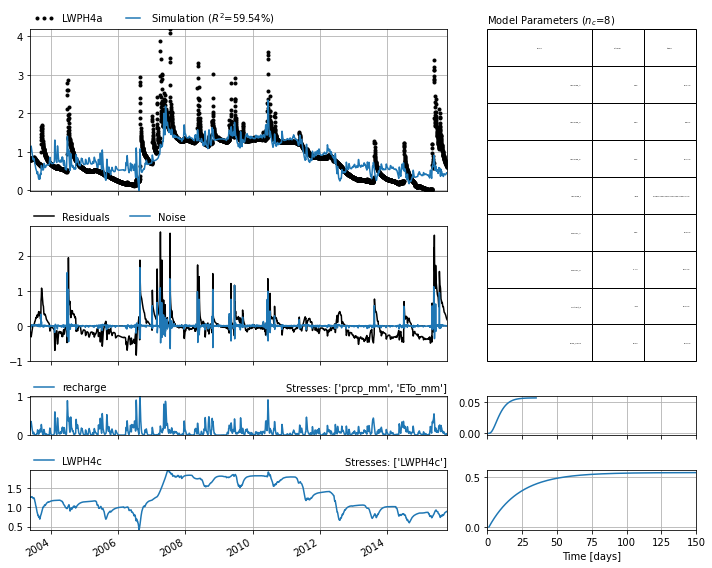

In [8]:
# delete stress model
ml_lwph4a.del_stressmodel("river")


# solve
ml_lwph4a.solve(noise=False, report=False) # Solve first without noise model to improve initial parameters
ml_lwph4a.solve(noise=True, initial=False)

# plot
ml_lwph4a.plots.results(figsize=(10, 8))

## Attempts from Raoul

- create models with prec, evap and river stage as explanatory variables
- normalize the river stage by subtracting the minimum, and fill nan's by 0.
- tried ps.One, ps.Exponential and ps.Gamma for both time series
- added tmin to ml.solve, because the systems seems to respond slow..

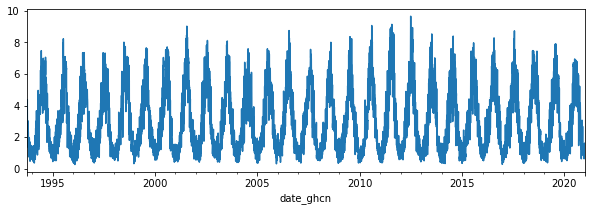

In [9]:
# Try to use a different Evaporation flux
import pyet
lon, lat = 38.27930316507861, -100.3114766523088
et = pyet.hamon(inputdata["tmax_c"].index, (inputdata["tmax_c"] + inputdata["tmin_c"])/2, lat)
et.plot(figsize=(10, 3));

INFO: Nan-values were removed at the start of the time series LWPH4a.
INFO: Nan-values were removed at the end of the time series LWPH4a.
INFO: Inferred frequency for time series LWPH4a: freq=D
INFO: Inferred frequency for time series prcp_mm: freq=D
INFO: Inferred frequency for time series None: freq=D
INFO: Inferred frequency for time series stage_masl: freq=D


Fit report LWPH4a                     Fit Statistics
nfev    22                     EVP           94.02
nobs    2923                   R2             0.94
noise   1                      RMSE           0.13
tmin    2006-01-01 00:00:00    AIC         3147.49
tmax    2014-01-01 00:00:00    BIC         3189.35
freq    D                      Obj            1.46
warmup  3650 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (7 optimized)
                 optimal   stderr      initial  vary
recharge_A      7.565548  ±17.61%     7.770470  True
recharge_n      1.241418   ±1.91%     1.213295  True
recharge_a   2553.793949  ±17.69%  2868.866079  True
recharge_f     -0.383458  ±19.23%    -0.406895  True
river_d         0.884930   ±0.54%     1.003438  True
constant_d    588.588963   ±0.15%   589.048285  True
noise_alpha    34.450880  ±12.46%     1.000000  True


INFO: Nan-values were removed at the start of the time series LWPH4b.
INFO: Nan-values were removed at the end of the time series LWPH4b.
INFO: Inferred frequency for time series LWPH4b: freq=D
INFO: Inferred frequency for time series prcp_mm: freq=D
INFO: Inferred frequency for time series None: freq=D
INFO: Inferred frequency for time series stage_masl: freq=D


Fit report LWPH4b                   Fit Statistics
nfev    24                     EVP           89.05
nobs    2923                   R2             0.89
noise   1                      RMSE           0.18
tmin    2006-01-01 00:00:00    AIC         2561.91
tmax    2014-01-01 00:00:00    BIC         2603.77
freq    D                      Obj            1.20
warmup  3650 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (7 optimized)
                optimal   stderr     initial  vary
recharge_A     1.514968  ±10.90%    1.492570  True
recharge_n    12.021625  ±20.05%   10.542234  True
recharge_a   107.452619  ±21.68%  123.610170  True
recharge_f    -1.779462  ±29.51%   -1.999997  True
river_d        0.838899   ±0.51%    1.066696  True
constant_d   598.154361   ±0.39%  599.008223  True
noise_alpha   77.920401  ±18.78%    1.000000  True


INFO: Nan-values were removed at the start of the time series LWPH4c.
INFO: Nan-values were removed at the end of the time series LWPH4c.
INFO: Inferred frequency for time series LWPH4c: freq=D
INFO: Inferred frequency for time series prcp_mm: freq=D
INFO: Inferred frequency for time series None: freq=D
INFO: Inferred frequency for time series stage_masl: freq=D


Fit report LWPH4c                   Fit Statistics
nfev    18                     EVP           89.62
nobs    2923                   R2             0.90
noise   1                      RMSE           0.23
tmin    2006-01-01 00:00:00    AIC         8996.01
tmax    2014-01-01 00:00:00    BIC         9043.85
freq    D                      Obj           10.80
warmup  3650 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (8 optimized)
                optimal   stderr     initial  vary
recharge_A     0.080438  ±19.06%    0.087084  True
recharge_a    46.218051  ±17.52%   22.920117  True
recharge_f    -2.000000  ±13.50%   -2.000000  True
river_A        5.404149   ±4.59%    5.600987  True
river_n        0.762686   ±4.46%    0.716707  True
river_a      478.612301  ±11.18%  520.711844  True
constant_d   592.447476   ±0.01%  592.439664  True
noise_alpha   13.740464   ±8.97%    1.000000  True


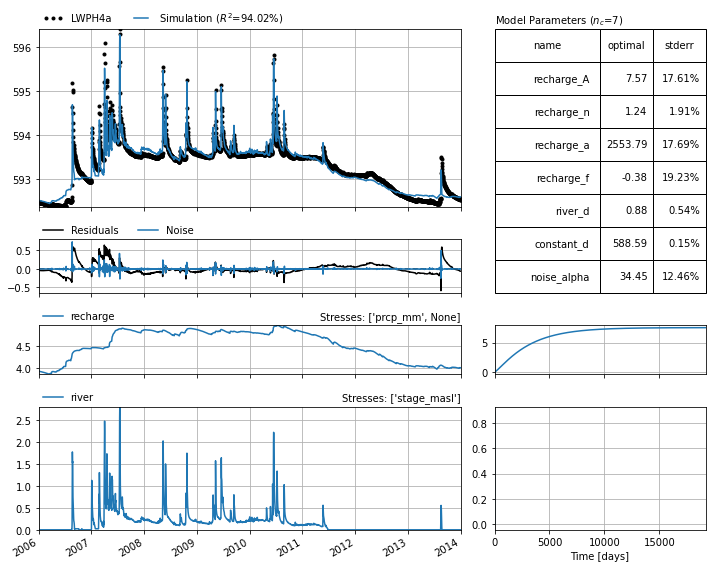

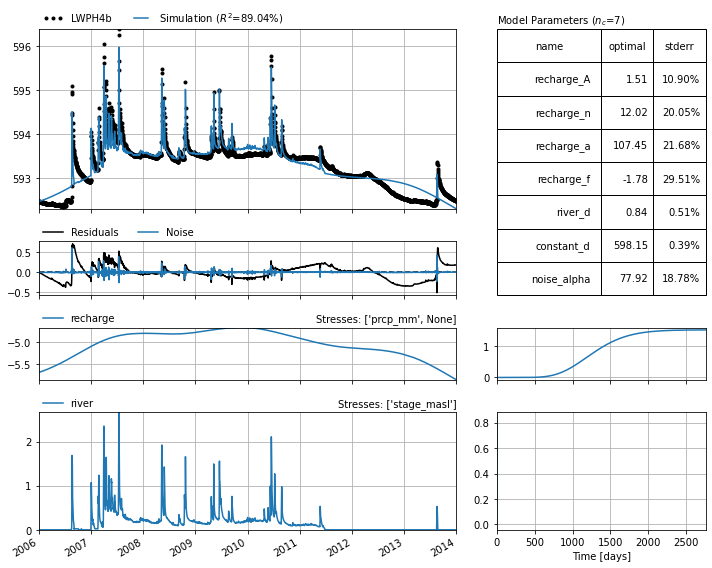

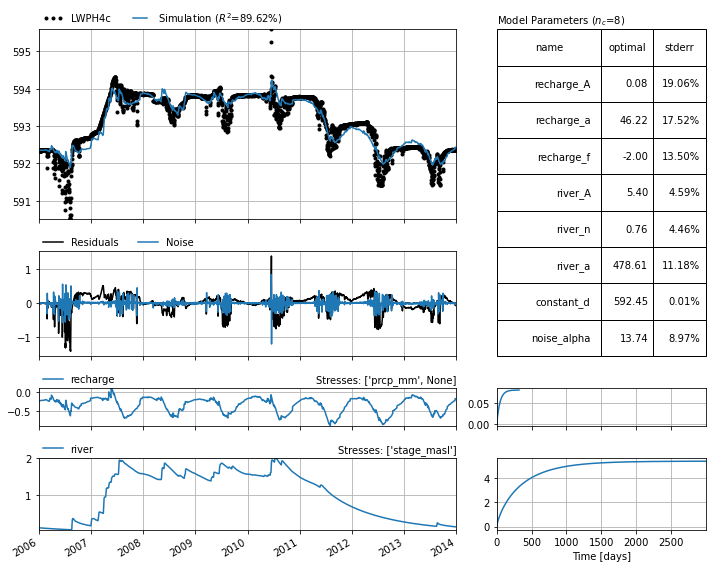

In [10]:
rfunc1 = ps.Gamma
rfunc2 = ps.One
river = (hydrodata["stage_masl"] - hydrodata["stage_masl"].min()).asfreq("D").fillna(0)

for name in "LWPH4a", "LWPH4b", "LWPH4c":
    if name =="LWPH4c":
        rfunc2 = ps.Gamma
        rfunc1 = ps.Exponential
        
    ml = ps.Model(hydrodata[name].iloc[::1], name=name)
    sm_rech = ps.RechargeModel(metdata["prcp_mm"], et, #metdata["ETo_mm"], 
                               rfunc=rfunc1, name="recharge")
    ml.add_stressmodel(sm_rech)

    sm_lwph4c = ps.StressModel(river, rfunc=rfunc2, name="river", settings="waterlevel")
    ml.add_stressmodel(sm_lwph4c)
    # solve
    ml.solve(noise=False, report=False, tmin="2006", tmax="2014") # Solve first without noise model to improve initial parameters
    ml.solve(noise=True, initial=False, report="basic", tmin="2006", tmax="2014")

    # plot
    ml.plots.results(figsize=(10, 8))

## Try different evaporation flux

INFO: Nan-values were removed at the start of the time series LWPH4a.
INFO: Nan-values were removed at the end of the time series LWPH4a.
INFO: Inferred frequency for time series LWPH4a: freq=D
INFO: Inferred frequency for time series prcp_mm: freq=D
INFO: Inferred frequency for time series None: freq=D
INFO: Time Series prcp_mm was extended to 1993-05-18 00:00:00 with the mean value of the time series.
INFO: Time Series None was extended to 1993-05-18 00:00:00 with the mean value of the time series.


Fit report LWPH4a                  Fit Statistics
nfev    16                     EVP           24.20
nobs    4543                   R2             0.24
noise   1                      RMSE           0.49
tmin    2003-05-16 00:00:00    AIC        16357.17
tmax    2015-10-22 00:00:00    BIC        16389.27
freq    D                      Obj           18.27
warmup  3650 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (5 optimized)
                optimal   stderr    initial  vary
recharge_A     0.841096  ±79.17%   0.139301  True
recharge_a   999.999999  ±83.32%  10.000000  True
recharge_f    -0.934297  ±54.08%  -1.000000  True
constant_d     1.875714  ±70.46%   0.888142  True
noise_alpha   57.367322  ±17.69%   1.000000  True


[<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:title={'right':"Stresses: ['prcp_mm', None]"}>,
 <AxesSubplot:xlabel='Time [days]'>,
 <AxesSubplot:title={'left':'Model Parameters ($n_c$=5)'}>]

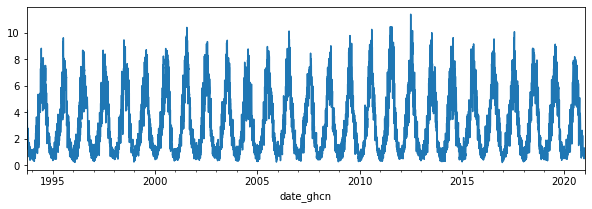

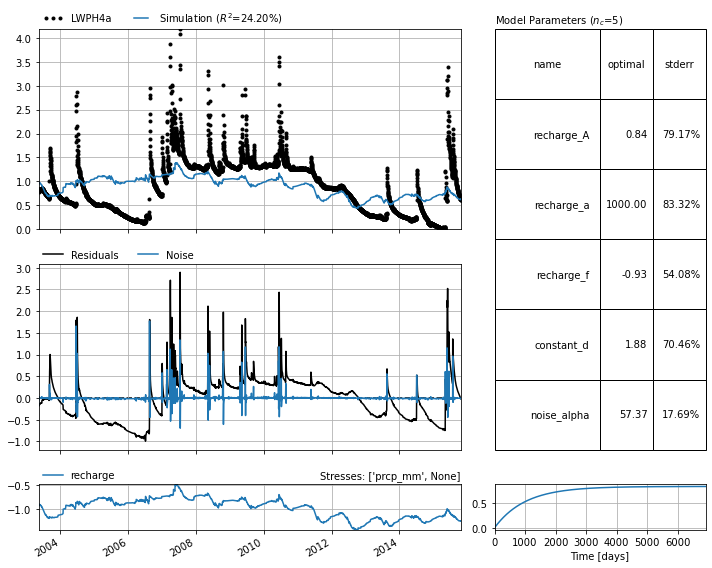

In [11]:
# Try to use a different Evaporation flux
import pyet
lon, lat = -99.0021388326013, 38.2036996032442
et = pyet.hamon(inputdata["tmax_c"].index, (inputdata["tmax_c"] + inputdata["tmin_c"])/2, lat)
et.plot(figsize=(10, 3));

# Create a model object by passing it the observed series
ml_lwph4a = ps.Model(lwph4a, name="LWPH4a")

# Add the recharge data as explanatory variable
#sm_precSurplus = ps.StressModel(precSurplus_mm, ps.Gamma, name='PrecSurplus', settings="evap")
#ml_lwph4a.add_stressmodel(sm_precSurplus)

# Add the recharge data as explanatory variable
sm_rech = ps.RechargeModel(metdata["prcp_mm"], et, rfunc=ps.Exponential, name="recharge")
ml_lwph4a.add_stressmodel(sm_rech)

# solve
ml_lwph4a.solve()

# plot
ml_lwph4a.plots.results(figsize=(10, 8))